In [97]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']

In [49]:
#cerco chi sono gli utenti che hanno votto di più
df= pd.DataFrame( db.ratings.aggregate([{'$group': {'_id': '$userId','total': {'$sum': 1}}},{'$sort':{'total': -1}},{'$limit': 5}
]))
df.head()

,_id,total
0,45811,18276
1,8659,9279
2,270123,7638
3,179792,7515
4,228291,7410


In [50]:
#una volta trovati prelevo le loro votazioni dalla collezione rating
df1 = pd.DataFrame(db.ratings.find({"$or": [{'userId':45811},{'userId':8659},{'userId':270123},{'userId':179792}]}))
df1.head()


,_id,userId,movieId,rating,timestamp
0,5f511290e1677cf95d3345be,8659,1,4.0,997044423
1,5f511290e1677cf95d3345bf,8659,2,4.0,997144402
2,5f511290e1677cf95d3345c0,8659,3,3.0,997144734
3,5f511290e1677cf95d3345c1,8659,4,3.0,997146175
4,5f511290e1677cf95d3345c2,8659,5,3.0,997145617


In [51]:
df1.userId.value_counts()

45811     18276
8659       9279
270123     7638
179792     7515
Name: userId, dtype: int64

In [52]:
#elimino colonna _id
df1.drop("_id",axis='columns', inplace=True)
df1.sample(5)

,userId,movieId,rating,timestamp
38924,270123,27773,4.0,1436135490
18572,45811,89472,3.0,1450162855
37010,270123,3932,4.0,1436135507
22186,45811,126795,4.0,1455271839
23780,45811,142052,2.5,1455488874


In [53]:
#lista dei film, nella collezione metadata
df2 = pd.DataFrame(db.metadata.find({}, {'_id':1, 'genres':1}))
df2

,_id,genres
0,862,"[16, 35, 10751]"
1,8844,"[12, 14, 10751]"
2,15602,"[10749, 35]"
3,31357,"[35, 18, 10749]"
4,11862,[35]
...,...,...
45431,439050,"[18, 10751]"
45432,111109,[18]
45433,67758,"[28, 18, 53]"
45434,227506,[]


In [54]:
#rinomino la colonna _id in movie_id
df2 =  df2.rename(columns = {'_id' : 'movieId'})

In [55]:
#elimino le righe che mi creavano problemi a causa di un id non convertibile in int
newdf2 = df2.drop([df2.index[19722] , df2.index[29483], df2.index[35564]])
newdf2      

,movieId,genres
0,862,"[16, 35, 10751]"
1,8844,"[12, 14, 10751]"
2,15602,"[10749, 35]"
3,31357,"[35, 18, 10749]"
4,11862,[35]
...,...,...
45431,439050,"[18, 10751]"
45432,111109,[18]
45433,67758,"[28, 18, 53]"
45434,227506,[]


In [56]:
#converto i vari id del dataframe da oggetti a int
newdf2.movieId = newdf2.movieId.astype(str).astype(int)

In [57]:
newdf2.dtypes

movieId     int32
genres     object
dtype: object

In [58]:
newdf2.genres[0]

[16, 35, 10751]

In [59]:
#utilizzo funzione explode, per creare nuove righe dagli elementi dell' array presenti nella colonna genres
newdf2 = newdf2.explode('genres')
newdf2.explode('genres')


,movieId,genres
0,862,16
0,862,35
0,862,10751
1,8844,12
1,8844,14
...,...,...
45433,67758,28
45433,67758,18
45433,67758,53
45434,227506,NaN


In [60]:
newdf2.head()

,movieId,genres
0,862,16
0,862,35
0,862,10751
1,8844,12
1,8844,14


In [61]:
#vedo quanti na ci sono 
newdf2.isna().sum()

movieId       0
genres     2442
dtype: int64

In [62]:
#prendo solo le righe dove non ci sono na
newdf2 = newdf2[newdf2['genres'].notna()]


In [63]:
#check per controllare se ci sono ancora na
newdf2.isna().sum()

movieId    0
genres     0
dtype: int64

In [64]:
newdf2.shape

(91015, 2)

In [65]:
#prendo i generi nella collezione genres
dfgenres = pd.DataFrame(db.genres.find({}))
dfgenres.head()

,_id,name
0,16,Animation
1,35,Comedy
2,10751,Family
3,12,Adventure
4,14,Fantasy


In [66]:
#rinomino la colonna _id in movie_id
dfgenres =  dfgenres.rename(columns = {'_id' : 'genres'})

In [67]:
dfgenres.head(2)

,genres,name
0,16,Animation
1,35,Comedy


In [68]:
#join con il dataframe contenente i vari id dei film
df_merge = pd.merge(dfgenres, newdf2, on='genres')
df_merge.head(2)

,genres,name,movieId
0,16,Animation,862
1,16,Animation,21032


In [69]:
df_merge.shape

(91015, 3)

In [70]:
#join con il dataframe contenente i 5 utenti scelti dalla collezione ratings
df_secondmerge = pd.merge(df1, df_merge, on='movieId')
df_secondmerge

,userId,movieId,rating,timestamp,genres,name
0,8659,2,4.0,997144402,18,Drama
1,8659,2,4.0,997144402,80,Crime
2,45811,2,3.0,1473241811,18,Drama
3,45811,2,3.0,1473241811,80,Crime
4,179792,2,3.0,1160533952,18,Drama
...,...,...,...,...,...,...
26063,270123,159109,1.5,1465361347,35,Comedy
26064,270123,159109,1.5,1465361347,18,Drama
26065,270123,159109,1.5,1465361347,27,Horror
26066,270123,159109,1.5,1465361347,9648,Mystery


In [71]:
#vediamo i dati di un singolo utente
df_H1=df_secondmerge[df_secondmerge['userId'] == 8659]
df_H1.head(5)

,userId,movieId,rating,timestamp,genres,name
0,8659,2,4.0,997144402,18,Drama
1,8659,2,4.0,997144402,80,Crime
8,8659,3,3.0,997144734,35,Comedy
9,8659,3,3.0,997144734,18,Drama
14,8659,5,3.0,997145617,35,Comedy


In [72]:
#raggruppiamo sul genere per vedere la votazione media data ad ogni genere da questo utente
df_mean = df_H1.groupby("name").agg({'rating':'mean'})

In [73]:
#il fatto di avere una maggioranza di voti per i drama, non dipende dal fatto che gli piacciono più i drama
df_mean.head(5)


,rating
name,
Action,3.330782
Adventure,3.341463
Animation,3.360825
Comedy,3.306399
Crime,3.357294


In [74]:
df_dramaH1 = df_H1[df_H1['name'] == "Drama"]


In [75]:
df_drama.rating.unique()

array([4. , 3. , 2.5, 3.5, 2. , 5. , 4.5])

In [76]:
#numero  di film votati dall' utente
len(df_H1.movieId.unique())

3002

In [77]:
#vediamo quante volte un utente ha votato un genere
df_H1 = df_H1.name.value_counts().rename_axis('unique_values').reset_index(name='number')


In [78]:
df_H1['Percentage'] = (df_H1['number']/df_H1['number'].sum())*100
df_H1['Percentage'] =  df_H1['Percentage'].round(decimals=2)

In [79]:
#possiamo notare che vi è una maggior prevalenza di votazioni per i film che appartengono al genere drama
df_H1.head(5)

,unique_values,number,Percentage
0,Drama,1649,22.58
1,Comedy,922,12.62
2,Thriller,724,9.91
3,Action,588,8.05
4,Romance,570,7.80


In [80]:
df_H2= df_secondmerge[df_secondmerge['userId'] == 45811]


In [81]:
df_dramaH2 = df_H2[df_H2['name'] == "Drama"]

In [82]:
df_H2 = df_H2.name.value_counts().rename_axis('unique_values').reset_index(name='number')
df_H2.head(5)

,unique_values,number
0,Drama,1814
1,Comedy,1023
2,Thriller,691
3,Romance,583
4,Action,577


In [83]:
df_H2['Percentage'] = (df_H2['number']/df_H2['number'].sum())*100
df_H2['Percentage'] =  df_H2['Percentage'].round(decimals=2)

In [84]:
df_H3= df_secondmerge[df_secondmerge['userId'] == 270123]


In [85]:
df_dramaH3 = df_H3[df_H3['name'] == "Drama"]

In [86]:
df_H3 = df_H3.name.value_counts().rename_axis('unique_values').reset_index(name='number')
df_H3.head(5)

,unique_values,number
0,Drama,1083
1,Comedy,613
2,Thriller,465
3,Romance,370
4,Action,355


In [87]:
df_H3['Percentage'] = (df_H3['number']/df_H3['number'].sum())*100
df_H3['Percentage'] =  df_H3['Percentage'].round(decimals=2)

# Grafici

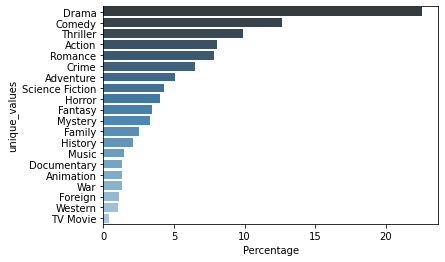

In [88]:
sns.barplot(x="Percentage", y="unique_values",data = df_H1, palette="Blues_d")


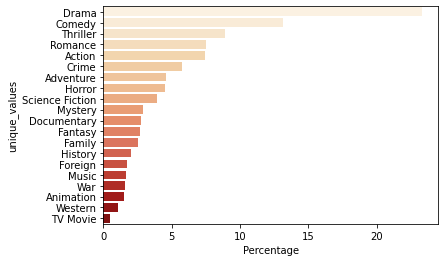

In [89]:
sns.barplot(x="Percentage", y="unique_values",data = df_H2, palette="OrRd")


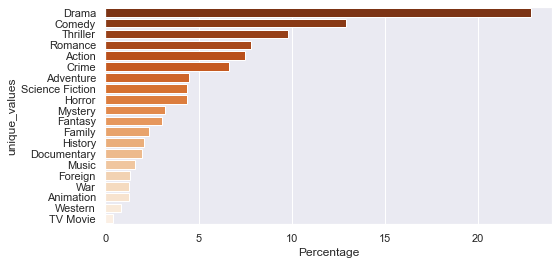

In [113]:
sns.barplot(x="Percentage", y="unique_values",data = df_H3, palette="Oranges_r")


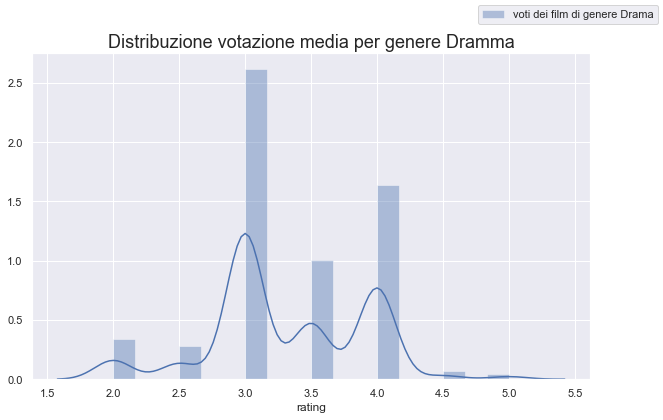

In [109]:
#analizzo la distribuzione di voti nei due casi analizzati
fig = plt.figure(figsize=(10,6))

sns.distplot(df_dramaH1['rating'], color = "b")
plt.title('Distribuzione votazione media per genere Dramma', fontsize=18)
fig.legend(labels=['voti dei film di genere Drama'])

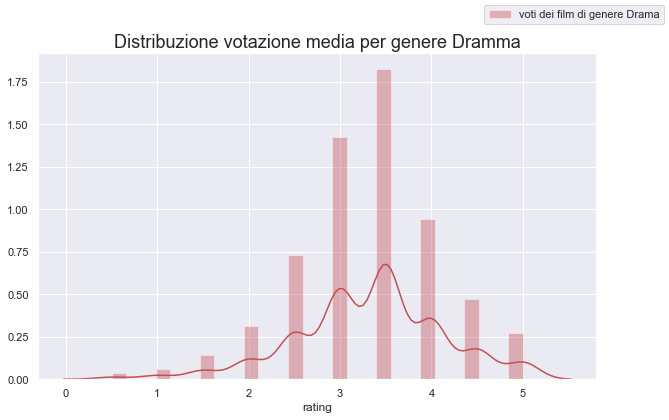

In [110]:
#analizzo la distribuzione di voti nei due casi analizzati
fig = plt.figure(figsize=(10,6))

sns.distplot(df_dramaH2['rating'],color="r")
plt.title('Distribuzione votazione media per genere Dramma', fontsize=18)
fig.legend(labels=['voti dei film di genere Drama'])

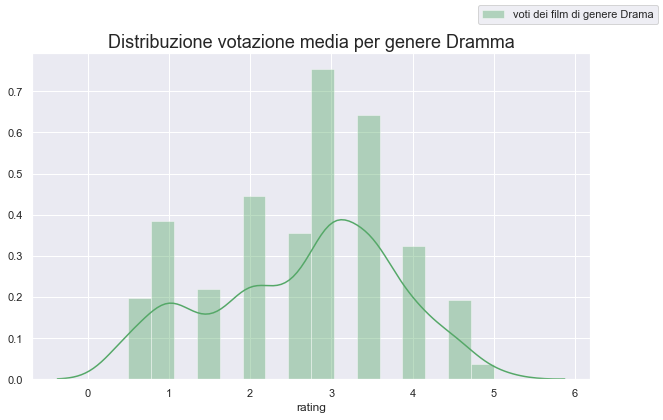

In [111]:
#analizzo la distribuzione di voti nei due casi analizzati
fig = plt.figure(figsize=(10,6))

sns.distplot(df_dramaH3['rating'],color="g")
plt.title('Distribuzione votazione media per genere Dramma', fontsize=18)
fig.legend(labels=['voti dei film di genere Drama'])

In [94]:
#vedere grafici distplot per capire se forse ha votato più drama perché li piace di più? e vedere se c'è correlazione tra il fatto di scegliere lo stesso genere e il voto,
#magari vota drama perchè li piace molto e quindi alla fine avrà un valore medio abbastanza alto